# LeNet and BatchNorm layer implementation 

## Motivation on Batch Normalization

In deep learning, changes in the distribution of the inputs to the inner nodes within a network can suppose a challenge for training. A neural network modifies the weights of each layer over the course of training. This means that the activations of each layer change as well. Since the activations of a previous layer are the inputs of the next layer, each layer in the neural network faces a situation where the input distribution is altered between epochs. This can posed a problem because it forces each layer to continuously adapt to its changing inputs. The basic idea behind batch normalization (BN) is to limit covariate shift by normalizing the activations of each layer (transforming inputs to mean 0 and unit variance). This allows each layer to learn on a more stable distribution of inputs, and therefore accelerates the training of the network. Batch normalization makes the mean and variance of the activations of each layer independent from the values themselves. In other words, the magnitude of the higher order interactions are going to be suppressed, allowing larger learning rates to be used.

## Intuition behind Batch Normalization

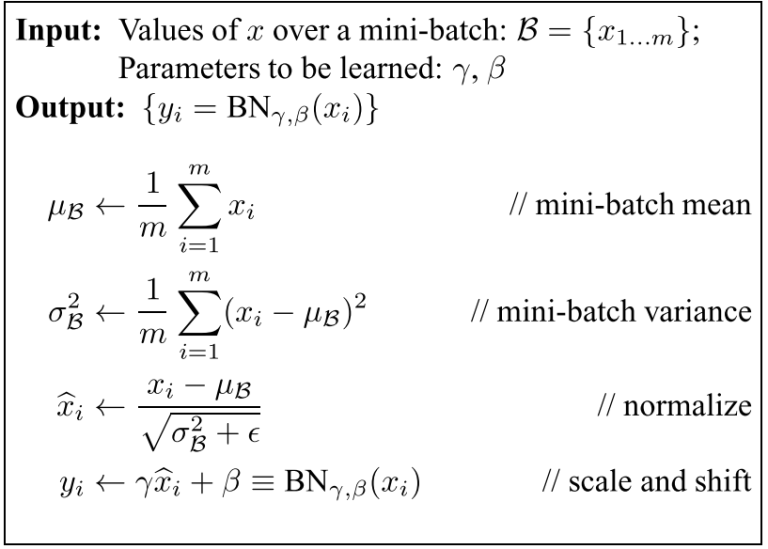

In [33]:
from IPython.display import Image
Image(filename='batchnorm_algorithm-1.png')

In practice, restricting the activations of each layer to be strictly 0 mean and unit variance can limit the expressive power of the network. Therefore, in practice, batch normalization allows the network to learn parameters gamma  and beta  that can convert the mean and variance to any value that the network desires.

The four equations shown above do the following:

1. Calculate mean of the minibatch.
2. Calculate variance of the minibatch.
3. Normalize by subtracting mean from z and subsequently dividing by standard deviation. A small number, epsilon, is added to the denominator to prevent divide by zero.
4. Calculate Yi by multiplying the normalized values with a scale, gamma, and adding a shift, beta, and use this normalized values in place of the original ones as the activation function input. The two parameters beta and gamma are learned during the training process.

The important property of batch normalization is that the mean and variance are not decided by complex interactions between multiple layers, but rather by two simple parameters. This simplification of the learning dynamic is the key property of batch normalization and why it improves performance.

## Import libraries

In [25]:
!pip install --user tensorflow==2.0.0beta1
!pip install --user matplotlib

  The scripts freeze_graph.exe, saved_model_cli.exe, tensorboard.exe, tf_upgrade_v2.exe, tflite_convert.exe, toco.exe and toco_from_protos.exe are installed in 'C:\Users\mcd95\AppData\Roaming\Python\Python36\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import tensorflow as tf

## Implementation of Batch Norm

In [22]:
class BN(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-3, trainable=True):
        super(BN, self).__init__()
        self.epsilon = epsilon
        self.trainable = trainable
    def build(self, input_shape):
        self.inp_shape = input_shape
        self.beta = tf.Variable(tf.constant(0.0, shape=[self.inp_shape[-1]]), name='beta', trainable=True)
        self.gamma = tf.Variable(tf.constant(1.0, shape=[self.inp_shape[-1]]), name='gamma', trainable=True)
 
    def call(self, inputs):
            if len(self.inp_shape) > 2:
                batch_mean, batch_var = tf.nn.moments(inputs, [0,1,2], name="moments")
            else:
                batch_mean, batch_var = tf.nn.moments(inputs, [0], name="moments")
            
            mean = tf.Variable(lambda: batch_mean)
            var = tf.Variable(lambda: batch_var)
            #Moving Averages not compatible yet with tf == 2.0.0 and Eager Execution
            #ema = tf.train.ExponentialMovingAverage(decay=0.5)
            #def mean_var_with_update():
            #        ema_apply_op = ema.apply([batch_mean, batch_var])
            #    with tf.control_dependencies([ema_apply_op]):
            #        return tf.identity(batch_mean), tf.identity(batch_var)

            #mean, var = tf.cond(tf.cast(self.trainable, tf.bool), mean_var_with_update, lambda: (ema.average(batch_mean), ema.average(batch_var)))
            z1_hat = (inputs - mean) / tf.math.sqrt(var + self.epsilon)
            normed = self.gamma * z1_hat + self.beta
        
            return normed

## Implementation of LeNet

In [23]:
class LeNet(tf.keras.Model):
    def __init__(self, batch_norm=False):
        super(LeNet, self).__init__()
        self.bn = batch_norm
        if self.bn:
            self.conv2d_1 = tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu')
            self.bn_1 = BN()
            self.avg_pool_1 = tf.keras.layers.AveragePooling2D()
            self.conv2d_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')
            self.bn_2 = BN()
            self.avg_pool_2 = tf.keras.layers.AveragePooling2D()
            self.flatten = tf.keras.layers.Flatten()
            self.fc_1 = tf.keras.layers.Dense(units=120, activation='relu')
            self.bn_3 = BN()
            self.fc_2 = tf.keras.layers.Dense(units=84, activation='relu')
            self.bn_4 = BN()
            self.classifier = tf.keras.layers.Dense(units=10, activation = 'softmax')
        else:
            self.conv2d_1 = tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu')
            #self.bn_1 = BN()
            self.avg_pool_1 = tf.keras.layers.AveragePooling2D()
            self.conv2d_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')
            #self.bn_2 = BN()
            self.avg_pool_2 = tf.keras.layers.AveragePooling2D()
            self.flatten = tf.keras.layers.Flatten()
            self.fc_1 = tf.keras.layers.Dense(units=120, activation='relu')
            #self.bn_3 = BN()
            self.fc_2 = tf.keras.layers.Dense(units=84, activation='relu')
            #self.bn_4 = BN()
            self.classifier = tf.keras.layers.Dense(units=10, activation = 'softmax')

    def call(self, inputs):
        if self.bn:
            x = self.conv2d_1(inputs)
            x = self.bn_1(x)
            x = self.avg_pool_1(x)
            x = self.conv2d_2(x)
            x = self.bn_2(x)
            x = self.avg_pool_2(x)
            x = self.flatten(x)
            x = self.fc_1(x)
            x = self.bn_3(x)
            x = self.fc_2(x)
            x = self.bn_4(x)
        else:
            x = self.conv2d_1(inputs)
            #x = self.bn_1(x)
            x = self.avg_pool_1(x)
            x = self.conv2d_2(x)
            #x = self.bn_2(x)
            x = self.avg_pool_2(x)
            x = self.flatten(x)
            x = self.fc_1(x)
            #x = self.bn_3(x)
            x = self.fc_2(x)
            #x = self.bn_4(x)
        return self.classifier(x)


## Testing on MNIST

In [4]:
batch_size = 64
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.reshape(-1, 28,28,1), y_train)).shuffle(360).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.reshape(-1 ,28,28,1), y_test)).shuffle(360).batch(batch_size)

In [24]:
lenet = LeNet()
optimizer = tf.keras.optimizers.Adam(1e-3)

lenet.compile(optimizer, loss="categorical_crossentropy", metrics=['categorical_accuracy', tf.metrics.AUC()])
history = lenet.fit(train_dataset, epochs=20, validation_data=test_dataset, verbose=1)

Epoch 1/20
938/938 [==============================] - 19s 20ms/step - loss: 0.2831 - categorical_accuracy: 0.8404 - auc: 0.9722 - val_loss: 0.0984 - val_categorical_accuracy: 0.9696 - val_auc: 0.9988
Epoch 2/20
938/938 [==============================] - 18s 19ms/step - loss: 0.0885 - categorical_accuracy: 0.9709 - auc: 0.9983 - val_loss: 0.0647 - val_categorical_accuracy: 0.9771 - val_auc: 0.9994
Epoch 3/20
938/938 [==============================] - 18s 20ms/step - loss: 0.0621 - categorical_accuracy: 0.9795 - auc: 0.9990 - val_loss: 0.0536 - val_categorical_accuracy: 0.9820 - val_auc: 0.9995
Epoch 4/20
938/938 [==============================] - 17s 18ms/step - loss: 0.0492 - categorical_accuracy: 0.9844 - auc: 0.9992 - val_loss: 0.0449 - val_categorical_accuracy: 0.9854 - val_auc: 0.9997
Epoch 5/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0400 - categorical_accuracy: 0.9874 - auc: 0.9994 - val_loss: 0.0440 - val_categorical_accuracy: 0.9859 - val_auc: 0.9995


In [25]:
lenet = LeNet(batch_norm=True)
optimizer = tf.keras.optimizers.Adam(1e-3)

lenet.compile(optimizer, loss="categorical_crossentropy", metrics=['categorical_accuracy', tf.metrics.AUC()])
history2 = lenet.fit(train_dataset, epochs=20, validation_data=test_dataset, verbose=1)

Epoch 1/20
938/938 [==============================] - 30s 32ms/step - loss: 0.1759 - categorical_accuracy: 0.8988 - auc_1: 0.9861 - val_loss: 0.0791 - val_categorical_accuracy: 0.9747 - val_auc_1: 0.9993
Epoch 2/20
938/938 [==============================] - 27s 29ms/step - loss: 0.0718 - categorical_accuracy: 0.9770 - auc_1: 0.9989 - val_loss: 0.0613 - val_categorical_accuracy: 0.9797 - val_auc_1: 0.9995
Epoch 3/20
938/938 [==============================] - 26s 28ms/step - loss: 0.0535 - categorical_accuracy: 0.9832 - auc_1: 0.9993 - val_loss: 0.0508 - val_categorical_accuracy: 0.9818 - val_auc_1: 0.9996
Epoch 4/20
938/938 [==============================] - 25s 27ms/step - loss: 0.0427 - categorical_accuracy: 0.9869 - auc_1: 0.9995 - val_loss: 0.0471 - val_categorical_accuracy: 0.9836 - val_auc_1: 0.9996
Epoch 5/20
938/938 [==============================] - 26s 28ms/step - loss: 0.0348 - categorical_accuracy: 0.9898 - auc_1: 0.9996 - val_loss: 0.0442 - val_categorical_accuracy: 0.9845 

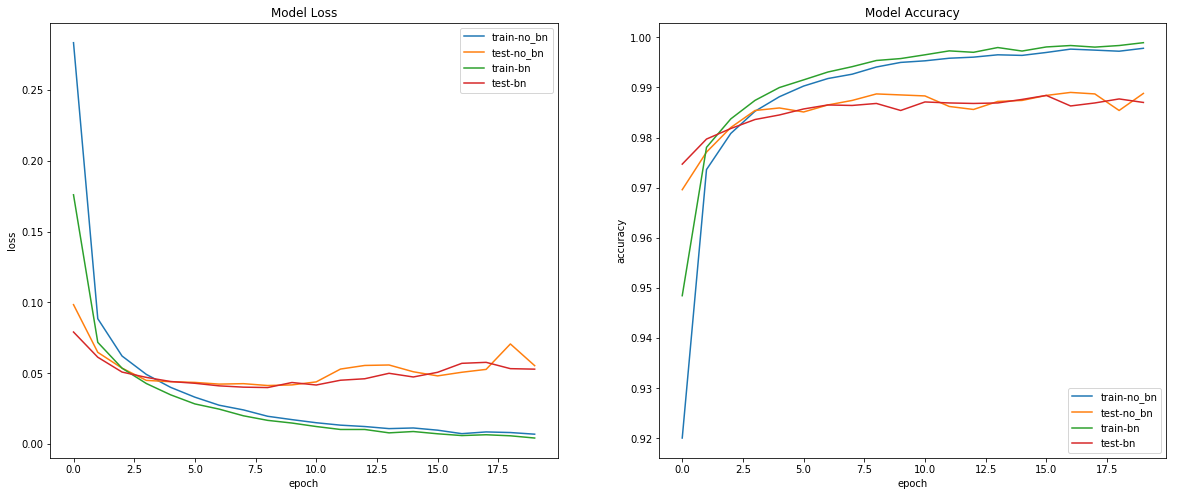

In [31]:
import matplotlib.pyplot as plt
# summarize history for loss
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-no_bn', 'test-no_bn', 'train-bn', 'test-bn'], loc='upper right')
# summarize history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train-no_bn', 'test-no_bn', 'train-bn', 'test-bn'], loc='lower right')



## Conclusions

These results suggests that BN fastens the training process improving also the performance of the model in terms of accuracy and loss. Although the differences are not quite large between both conditions, it's clear the effect at initial stages during training. We can see how the loss is much lower in the model with BN. In terms of accuracy, the model with BN reaches higher accuracies sooner than the model without. Still, predicting the label of a handwritten number is a quite easy task for a Neural Network, the improvement would be accentuated in other more complex datasets. In conclusion, BN helps the model train much faster and reach better results thanks to the reduction in the variability between distributions in batches of samples. 

## Bonus

Epoch 1/20
938/938 [==============================] - 52s 56ms/step - loss: 0.1599 - categorical_accuracy: 0.9038 - auc_2: 0.9858 - val_loss: 0.0551 - val_categorical_accuracy: 0.9813 - val_auc_2: 0.9996
Epoch 2/20
938/938 [==============================] - 50s 53ms/step - loss: 0.0550 - categorical_accuracy: 0.9803 - auc_2: 0.9994 - val_loss: 0.0390 - val_categorical_accuracy: 0.9871 - val_auc_2: 0.9997
Epoch 3/20
938/938 [==============================] - 50s 53ms/step - loss: 0.0386 - categorical_accuracy: 0.9872 - auc_2: 0.9995 - val_loss: 0.0334 - val_categorical_accuracy: 0.9893 - val_auc_2: 0.9996
Epoch 4/20
938/938 [==============================] - 51s 54ms/step - loss: 0.0279 - categorical_accuracy: 0.9901 - auc_2: 0.9997 - val_loss: 0.0337 - val_categorical_accuracy: 0.9898 - val_auc_2: 0.9995
Epoch 5/20
938/938 [==============================] - 52s 55ms/step - loss: 0.0206 - categorical_accuracy: 0.9934 - auc_2: 0.9998 - val_loss: 0.0469 - val_categorical_accuracy: 0.9846 

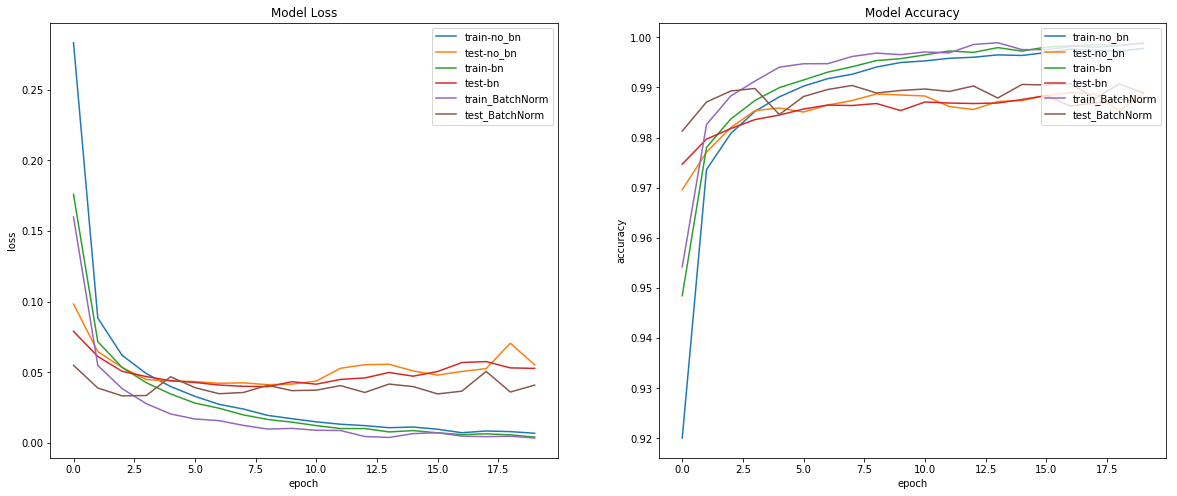

In [32]:
class LeNet(tf.keras.Model):
    def __init__(self, batch_norm=False):
        super(LeNet, self).__init__()
        self.bn = batch_norm
        if self.bn:
            self.conv2d_1 = tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu')
            self.bn_1 = tf.keras.layers.BatchNormalization()
            self.avg_pool_1 = tf.keras.layers.AveragePooling2D()
            self.conv2d_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')
            self.bn_2 = tf.keras.layers.BatchNormalization()
            self.avg_pool_2 = tf.keras.layers.AveragePooling2D()
            self.flatten = tf.keras.layers.Flatten()
            self.fc_1 = tf.keras.layers.Dense(units=120, activation='relu')
            self.bn_3 = tf.keras.layers.BatchNormalization()
            self.fc_2 = tf.keras.layers.Dense(units=84, activation='relu')
            self.bn_4 = tf.keras.layers.BatchNormalization()
            self.classifier = tf.keras.layers.Dense(units=10, activation = 'softmax')
        else:
            self.conv2d_1 = tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu')
            #self.bn_1 = BN()
            self.avg_pool_1 = tf.keras.layers.AveragePooling2D()
            self.conv2d_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')
            #self.bn_2 = BN()
            self.avg_pool_2 = tf.keras.layers.AveragePooling2D()
            self.flatten = tf.keras.layers.Flatten()
            self.fc_1 = tf.keras.layers.Dense(units=120, activation='relu')
            #self.bn_3 = BN()
            self.fc_2 = tf.keras.layers.Dense(units=84, activation='relu')
            #self.bn_4 = BN()
            self.classifier = tf.keras.layers.Dense(units=10, activation = 'softmax')

    def call(self, inputs):
        if self.bn:
            x = self.conv2d_1(inputs)
            x = self.bn_1(x)
            x = self.avg_pool_1(x)
            x = self.conv2d_2(x)
            x = self.bn_2(x)
            x = self.avg_pool_2(x)
            x = self.flatten(x)
            x = self.fc_1(x)
            x = self.bn_3(x)
            x = self.fc_2(x)
            x = self.bn_4(x)
        else:
            x = self.conv2d_1(inputs)
            #x = self.bn_1(x)
            x = self.avg_pool_1(x)
            x = self.conv2d_2(x)
            #x = self.bn_2(x)
            x = self.avg_pool_2(x)
            x = self.flatten(x)
            x = self.fc_1(x)
            #x = self.bn_3(x)
            x = self.fc_2(x)
            #x = self.bn_4(x)
        return self.classifier(x)
    
    
lenet = LeNet(batch_norm=True)
optimizer = tf.keras.optimizers.Adam(1e-3)

lenet.compile(optimizer, loss="categorical_crossentropy", metrics=['categorical_accuracy', tf.metrics.AUC()])
history3 = lenet.fit(train_dataset, epochs=20, validation_data=test_dataset, verbose=1)

import matplotlib.pyplot as plt
# summarize history for loss
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-no_bn', 'test-no_bn', 'train-bn', 'test-bn', "train_BatchNorm", "test_BatchNorm"], loc='upper right')
# summarize history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train-no_bn', 'test-no_bn', 'train-bn', 'test-bn', "train_BatchNorm", "test_BatchNorm"], loc='upper right')